In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd "/content/drive/My Drive/nyc-taxi-trip-duration"
!ls

/content/drive/My Drive/nyc-taxi-trip-duration
catboost_info  NYC_Taxi_Duration.ipynb	train.csv
LGB.csv        sample_submission.zip	XGB.csv
LGB_test.csv   test.csv			XGB_test.csv


In [4]:
import pandas as pd
train_df=pd.read_csv('train.csv')
print(train_df.shape)
display(train_df.head())
test_df=pd.read_csv('test.csv')
print(test_df.shape)
display(test_df.head())

(1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


(625134, 9)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [0]:
train_df.drop('dropoff_datetime',axis=1,inplace=True)

In [6]:
quantile99=train_df['trip_duration'].quantile(0.99)
train_df=train_df[train_df['trip_duration']<=quantile99]
print(train_df['trip_duration'].describe())

count    1.444069e+06
mean     8.074884e+02
std      5.754915e+02
min      1.000000e+00
25%      3.950000e+02
50%      6.560000e+02
75%      1.058000e+03
max      3.440000e+03
Name: trip_duration, dtype: float64


In [0]:
train_df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

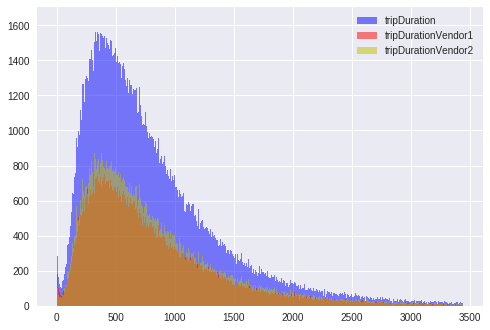

In [0]:
from matplotlib import pyplot

vendor1=train_df[train_df['vendor_id']==1]['trip_duration']
vendor2=train_df[train_df['vendor_id']==2]['trip_duration']

bins=train_df['trip_duration'].nunique()
bins1=len(set(vendor1))
bins2=len(set(vendor2))

pyplot.hist(train_df['trip_duration'], bins, alpha=0.5, label='tripDuration', color='b')
pyplot.hist(vendor1, bins1, alpha=0.5, label='tripDurationVendor1', color='r')
pyplot.hist(vendor2, bins2, alpha=0.5, label='tripDurationVendor2', color='y')

pyplot.legend(loc='upper right')
pyplot.show()

In [0]:
print("Latest pickup at : ",train_df['pickup_datetime'].max()," and Earliest at : ",train_df['pickup_datetime'].min())

Latest pickup at :  2016-06-30 23:59:39  and Earliest at :  2016-01-01 00:00:17


In [7]:
train_df['pickup_datetime']= pd.to_datetime(train_df['pickup_datetime'])

train_df['Month']=train_df['pickup_datetime'].apply(lambda x: x.month)
train_df['Day']=train_df['pickup_datetime'].apply(lambda x: x.day)
train_df['Hour']=train_df['pickup_datetime'].apply(lambda x: x.hour)

display(train_df.head())

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Month,Day,Hour
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,17
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,11
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,19
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,13


In [8]:
test_df['pickup_datetime']= pd.to_datetime(test_df['pickup_datetime'])

test_df['Month']=test_df['pickup_datetime'].apply(lambda x: x.month)
test_df['Day']=test_df['pickup_datetime'].apply(lambda x: x.day)
test_df['Hour']=test_df['pickup_datetime'].apply(lambda x: x.hour)

display(test_df.head())

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,Month,Day,Hour
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,6,30,23
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,6,30,23
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,6,30,23
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,6,30,23
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,6,30,23


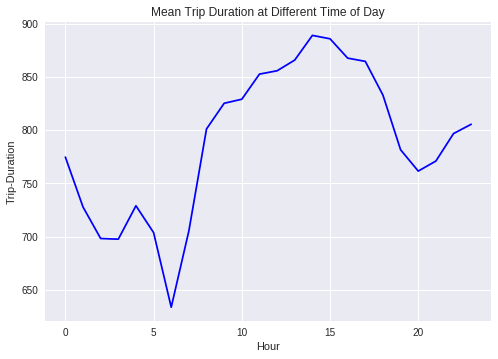

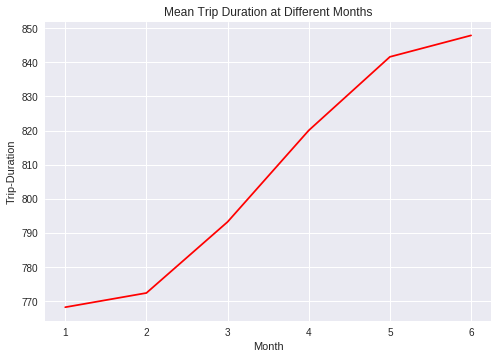

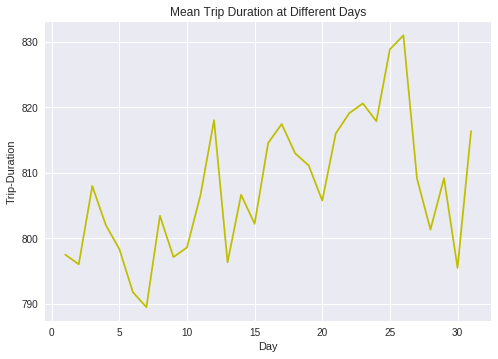

In [0]:
import matplotlib.pyplot as plt

duration_Hour=train_df.groupby(by='Hour',as_index=False)['trip_duration'].mean()
plt.plot(duration_Hour['Hour'],duration_Hour['trip_duration'],c='b')
plt.title("Mean Trip Duration at Different Time of Day")
plt.xlabel("Hour")
plt.ylabel("Trip-Duration")
plt.show()

duration_Month=train_df.groupby(by='Month',as_index=False)['trip_duration'].mean()
plt.plot(duration_Month['Month'],duration_Month['trip_duration'],c='r')
plt.title("Mean Trip Duration at Different Months")
plt.xlabel("Month")
plt.ylabel("Trip-Duration")
plt.show()

duration_Day=train_df.groupby(by='Day',as_index=False)['trip_duration'].mean()
plt.plot(duration_Day['Day'],duration_Day['trip_duration'],c='y')
plt.title("Mean Trip Duration at Different Days")
plt.xlabel("Day")
plt.ylabel("Trip-Duration")
plt.show()


Much variation in trip duration at different Hours and Months.

In [0]:
print("Latest pickup in test Set at : ",test_df['pickup_datetime'].max()," and Earliest at : ",test_df['pickup_datetime'].min())

Latest pickup in test Set at :  2016-06-30 23:59:58  and Earliest at :  2016-01-01 00:00:22


In [0]:
print(train_df['passenger_count'].value_counts())

1    1024120
2     207672
5      77220
3      59209
6      47775
4      28009
0         59
7          3
9          1
8          1
Name: passenger_count, dtype: int64


In [0]:
print(test_df['passenger_count'].value_counts())
print("Trip Duration for num of passengers = 7 in trip")
print(train_df[train_df['passenger_count']==7]['trip_duration'])
print("Trip Duration for num of passengers = 8 in trip")
print(train_df[train_df['passenger_count']==8]['trip_duration'])
print("Trip Duration for num of passengers = 9 in trip")
print(train_df[train_df['passenger_count']==9]['trip_duration'])

1    443447
2     90027
5     33411
3     25686
6     20521
4     12017
0        23
9         2
Name: passenger_count, dtype: int64
Trip Duration for num of passengers = 7 in trip
433304    19
489613    15
824904    25
Name: trip_duration, dtype: int64
Trip Duration for num of passengers = 8 in trip
826064    104
Name: trip_duration, dtype: int64
Trip Duration for num of passengers = 9 in trip
436047    560
Name: trip_duration, dtype: int64


In [9]:
train_df=train_df[ (train_df['passenger_count']!=7) & (train_df['passenger_count']!=8)]
print(train_df['passenger_count'].value_counts())

1    1024120
2     207672
5      77220
3      59209
6      47775
4      28009
0         59
9          1
Name: passenger_count, dtype: int64


Text(0.5, 1.0, 'Trip Duration Histogram for 3 passengers in trip')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


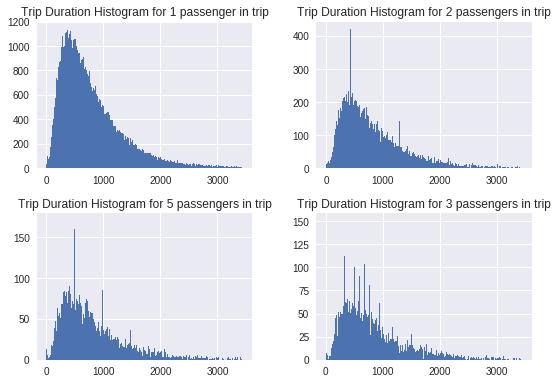

In [0]:
import matplotlib.pyplot as plt
num1=train_df[train_df['passenger_count']==1]['trip_duration']
num2=train_df[train_df['passenger_count']==2]['trip_duration']
num5=train_df[train_df['passenger_count']==5]['trip_duration']
num3=train_df[train_df['passenger_count']==3]['trip_duration']

fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0,0].hist(num1,bins=num1.nunique())
axs[0,0].set_title("Trip Duration Histogram for 1 passenger in trip")

axs[0,1].hist(num2,bins=num2.nunique())
axs[0,1].set_title("Trip Duration Histogram for 2 passengers in trip")

axs[1,0].hist(num5,bins=num5.nunique())
axs[1,0].set_title("Trip Duration Histogram for 5 passengers in trip")

axs[1,1].hist(num3,bins=num3.nunique())
axs[1,1].set_title("Trip Duration Histogram for 3 passengers in trip")


Not much variation in trip duration for different number of passengers.

In [0]:
print("Mean Trip Duration for 1 Passenger : ",num1.mean())
print("Mean Trip Duration for 2 Passenger : ",num2.mean())
print("Mean Trip Duration for 5 Passenger : ",num5.mean())
print("Mean Trip Duration for 3 Passenger : ",num3.mean())

Mean Trip Duration for 1 Passenger :  797.6480353864781
Mean Trip Duration for 2 Passenger :  839.8006953272468
Mean Trip Duration for 5 Passenger :  816.0620564620565
Mean Trip Duration for 3 Passenger :  834.9294532925737


In [0]:
print("Mean of Pickup longitude in train set : ",train_df['pickup_longitude'].mean())
print("Min of Pickup longitude in train set : ",train_df['pickup_longitude'].min())
print("Max of Pickup longitude in train set : ",train_df['pickup_longitude'].max())

print("Mean of Pickup longitude in test set : ",test_df['pickup_longitude'].mean() )
print("Min of Pickup longitude in test set : ",test_df['pickup_longitude'].min() )
print("Max of Pickup longitude in test set : ",test_df['pickup_longitude'].max() )

print("For pickup_longitude in train set, .99 quantile at : ",train_df['pickup_longitude'].quantile(0.99)," and 0.01 quantile at :",train_df['pickup_longitude'].quantile(0.01) )
print("For pickup_longitude in test set, .99 quantile at : ",test_df['pickup_longitude'].quantile(0.99)," and 0.01 quantile at :",test_df['pickup_longitude'].quantile(0.01) )


Mean of Pickup longitude in train set :  -73.97429920192874
Min of Pickup longitude in train set :  -121.93334197998048
Max of Pickup longitude in train set :  -61.33552932739258
Mean of Pickup longitude in test set :  -73.97361432244571
Min of Pickup longitude in test set :  -121.9331283569336
Max of Pickup longitude in test set :  -69.24891662597656
For pickup_longitude in train set, .99 quantile at :  -73.78340911865234  and 0.01 quantile at : -74.01432037353516
For pickup_longitude in test set, .99 quantile at :  -73.78231811523438  and 0.01 quantile at : -74.01433563232422


In [0]:
print("Mean of Pickup latitude in train set : ",train_df['pickup_latitude'].mean())
print("Min of Pickup latitude in train set : ",train_df['pickup_latitude'].min())
print("Max of Pickup latitude in train set : ",train_df['pickup_latitude'].max())

print("Mean of Pickup latitude in test set : ",test_df['pickup_latitude'].mean() )
print("Min of Pickup latitude in test set : ",test_df['pickup_latitude'].min() )
print("Max of Pickup latitude in test set : ",test_df['pickup_latitude'].max() )

print("For pickup_latitude in train set, .99 quantile at : ",train_df['pickup_latitude'].quantile(0.99)," and 0.01 quantile at :",train_df['pickup_latitude'].quantile(0.01) )
print("For pickup_latitude in test set, .99 quantile at : ",test_df['pickup_latitude'].quantile(0.99)," and 0.01 quantile at :",test_df['pickup_latitude'].quantile(0.01) )

Mean of Pickup latitude in train set :  40.75132183492026
Min of Pickup latitude in train set :  34.359695434570305
Max of Pickup latitude in train set :  51.88108444213867
Mean of Pickup latitude in test set :  40.75092741194779
Min of Pickup latitude in test set :  37.38958740234375
Max of Pickup latitude in test set :  42.814937591552734
For pickup_latitude in train set, .99 quantile at :  40.80663299560547  and 0.01 quantile at : 40.64515686035156
For pickup_latitude in test set, .99 quantile at :  40.806236267089844  and 0.01 quantile at : 40.64484786987305


In [0]:
print("Mean of dropoff longitude in train set : ",train_df['dropoff_longitude'].mean())
print("Min of dropoff longitude in train set : ",train_df['dropoff_longitude'].min())
print("Max of dropoff longitude in train set : ",train_df['dropoff_longitude'].max())

print("Mean of dropoff longitude in test set : ",test_df['dropoff_longitude'].mean() )
print("Min of dropoff longitude in test set : ",test_df['dropoff_longitude'].min() )
print("Max of dropoff longitude in test set : ",test_df['dropoff_longitude'].max() )

print("For dropoff_longitude in train set, .99 quantile at : ",train_df['dropoff_longitude'].quantile(0.99)," and 0.01 quantile at :",train_df['dropoff_longitude'].quantile(0.01) )
print("For dropoff_longitude in test set, .99 quantile at : ",test_df['dropoff_longitude'].quantile(0.99)," and 0.01 quantile at :",test_df['dropoff_longitude'].quantile(0.01) )

Mean of dropoff longitude in train set :  -73.97377822928598
Min of dropoff longitude in train set :  -121.9333038330078
Max of dropoff longitude in train set :  -61.33552932739258
Mean of dropoff longitude in test set :  -73.97345807131461
Min of dropoff longitude in test set :  -121.9333267211914
Max of dropoff longitude in test set :  -67.49679565429689
For dropoff_longitude in train set, .99 quantile at :  -73.80608093261719  and 0.01 quantile at : -74.01517486572266
For dropoff_longitude in test set, .99 quantile at :  -73.79056549072266  and 0.01 quantile at : -74.01515960693358


In [0]:
print("Mean of dropoff latitude in train set : ",train_df['dropoff_latitude'].mean())
print("Min of dropoff latitude in train set : ",train_df['dropoff_latitude'].min())
print("Max of dropoff latitude in train set : ",train_df['dropoff_latitude'].max())

print("Mean of dropoff latitude in test set : ",test_df['dropoff_latitude'].mean() )
print("Min of dropoff latitude in test set : ",test_df['dropoff_latitude'].min() )
print("Max of dropoff latitude in test set : ",test_df['dropoff_latitude'].max() )

print("For dropoff_latitude in train set, .99 quantile at : ",train_df['dropoff_latitude'].quantile(0.99)," and 0.01 quantile at :",train_df['dropoff_latitude'].quantile(0.01) )
print("For dropoff_latitude in test set, .99 quantile at : ",test_df['dropoff_latitude'].quantile(0.99)," and 0.01 quantile at :",test_df['dropoff_latitude'].quantile(0.01) )

Mean of dropoff latitude in train set :  40.752053481725405
Min of dropoff latitude in train set :  32.1811408996582
Max of dropoff latitude in train set :  43.92102813720703
Mean of dropoff latitude in test set :  40.75181605447947
Min of dropoff latitude in test set :  36.601322174072266
Max of dropoff latitude in test set :  48.85759735107422
For dropoff_latitude in train set, .99 quantile at :  40.83614349365234  and 0.01 quantile at : 40.64672470092773
For dropoff_latitude in test set, .99 quantile at :  40.83615749359131  and 0.01 quantile at : 40.64527256011963


In [10]:
print(train_df['store_and_fwd_flag'].value_counts())
train_df['store_and_fwd_flag']=train_df['store_and_fwd_flag'].apply(lambda row: 1 if row=='N' else 0)
display(train_df.head())

N    1436265
Y       7800
Name: store_and_fwd_flag, dtype: int64


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Month,Day,Hour
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,1,455,3,14,17
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,1,663,6,12,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,1,2124,1,19,11
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,1,429,4,6,19
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,1,435,3,26,13


In [11]:
test_df['store_and_fwd_flag']=test_df['store_and_fwd_flag'].apply(lambda row: 1 if row=='N' else 0)
print(test_df['store_and_fwd_flag'].value_counts())

1    621704
0      3430
Name: store_and_fwd_flag, dtype: int64


In [0]:
import matplotlib.pyplot as plt
import numpy as np

Y=np.array(train_df[train_df['store_and_fwd_flag']==0]['trip_duration'])
Y=Y.reshape(len(Y),1)
Y=pd.DataFrame(Y,columns=['Duration'])
print(Y['Duration'].describe())

N=np.array(train_df[train_df['store_and_fwd_flag']==1]['trip_duration'])
N=N.reshape(len(N),1)
N=pd.DataFrame(N,columns=['Duration'])
print(N['Duration'].describe())

count    7800.000000
mean      977.461154
std       713.270552
min         2.000000
25%       444.000000
50%       784.000000
75%      1328.000000
max      3430.000000
Name: Duration, dtype: float64
count    1.436265e+06
mean     8.065674e+02
std      5.745155e+02
min      1.000000e+00
25%      3.940000e+02
50%      6.560000e+02
75%      1.057000e+03
max      3.440000e+03
Name: Duration, dtype: float64


In [12]:


def dist_features(train_df):
  train_df['long_diff']=(train_df['dropoff_longitude']-train_df['pickup_longitude']).abs()
  train_df['latt_diff']=(train_df['dropoff_latitude']-train_df['pickup_latitude']).abs()
  train_df['euclidean_dist']=((train_df['long_diff']**2)+(train_df['latt_diff']**2))**0.5
  train_df['manhattan_dist']=train_df['long_diff']+train_df['latt_diff']
  return train_df
  
train_df=dist_features(train_df)
test_df=dist_features(test_df)

train_df.drop(['id','pickup_datetime'],axis=1,inplace=True)
test_df.drop(['id','pickup_datetime'],axis=1,inplace=True)

display(train_df.head())
display(test_df.head())

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Month,Day,Hour,long_diff,latt_diff,euclidean_dist,manhattan_dist
0,2,1,-73.982155,40.767937,-73.964630,40.765602,1,455,3,14,17,0.017525,0.002335,0.017680,0.019859
1,1,1,-73.980415,40.738564,-73.999481,40.731152,1,663,6,12,0,0.019066,0.007412,0.020456,0.026478
2,2,1,-73.979027,40.763939,-74.005333,40.710087,1,2124,1,19,11,0.026306,0.053852,0.059934,0.080158
3,2,1,-74.010040,40.719971,-74.012268,40.706718,1,429,4,6,19,0.002228,0.013252,0.013438,0.015480
4,2,1,-73.973053,40.793209,-73.972923,40.782520,1,435,3,26,13,0.000130,0.010689,0.010690,0.010818


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,Month,Day,Hour,long_diff,latt_diff,euclidean_dist,manhattan_dist
0,1,1,-73.988129,40.732029,-73.990173,40.756680,1,6,30,23,0.002045,0.024651,0.024735,0.026695
1,1,1,-73.964203,40.679993,-73.959808,40.655403,1,6,30,23,0.004395,0.024590,0.024979,0.028984
2,1,1,-73.997437,40.737583,-73.986160,40.729523,1,6,30,23,0.011276,0.008060,0.013861,0.019337
3,2,1,-73.956070,40.771900,-73.986427,40.730469,1,6,30,23,0.030357,0.041431,0.051363,0.071789
4,1,1,-73.970215,40.761475,-73.961510,40.755890,1,6,30,23,0.008705,0.005585,0.010343,0.014290


(0, 0.5)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


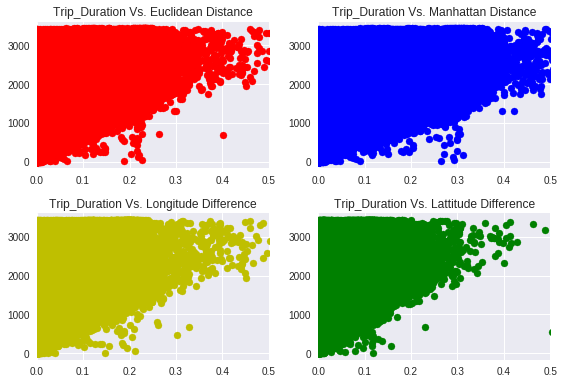

In [0]:
fig, axs = plt.subplots(2, 2, tight_layout=True)

axs[0,0].scatter(train_df['euclidean_dist'],train_df['trip_duration'],c='r')
axs[0,0].set_title("Trip_Duration Vs. Euclidean Distance")
axs[0,0].set_xlim([0,0.5])

axs[0,1].scatter(train_df['manhattan_dist'],train_df['trip_duration'],c='b')
axs[0,1].set_title("Trip_Duration Vs. Manhattan Distance")
axs[0,1].set_xlim([0,0.5])

axs[1,0].scatter(train_df['long_diff'],train_df['trip_duration'],c='y')
axs[1,0].set_title("Trip_Duration Vs. Longitude Difference")
axs[1,0].set_xlim([0,0.5])

axs[1,1].scatter(train_df['latt_diff'],train_df['trip_duration'],c='g')
axs[1,1].set_title("Trip_Duration Vs. Lattitude Difference")
axs[1,1].set_xlim([0,0.5])

In [13]:
import datetime

def day_of_week(day,month):
  year = 2016    
  ans = datetime.date(year, month, day)
  return ans.strftime("%A")

train_df['day_of_week']=train_df.apply(lambda row: day_of_week(int(row['Day']),int(row['Month'])),axis=1)
 
display(train_df.head())

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,Month,Day,Hour,long_diff,latt_diff,euclidean_dist,manhattan_dist,day_of_week
0,2,1,-73.982155,40.767937,-73.964630,40.765602,1,455,3,14,17,0.017525,0.002335,0.017680,0.019859,Monday
1,1,1,-73.980415,40.738564,-73.999481,40.731152,1,663,6,12,0,0.019066,0.007412,0.020456,0.026478,Sunday
2,2,1,-73.979027,40.763939,-74.005333,40.710087,1,2124,1,19,11,0.026306,0.053852,0.059934,0.080158,Tuesday
3,2,1,-74.010040,40.719971,-74.012268,40.706718,1,429,4,6,19,0.002228,0.013252,0.013438,0.015480,Wednesday
4,2,1,-73.973053,40.793209,-73.972923,40.782520,1,435,3,26,13,0.000130,0.010689,0.010690,0.010818,Saturday


In [0]:
test_df['day_of_week']=test_df.apply(lambda row: day_of_week(int(row['Day']),int(row['Month'])),axis=1)

In [15]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train_df['day_of_week']=le.fit(train_df['day_of_week']).transform(train_df['day_of_week'])
test_df['day_of_week']=le.fit(test_df['day_of_week']).transform(test_df['day_of_week'])

print(train_df['day_of_week'].value_counts())
print(test_df['day_of_week'].value_counts())

0    220753
2    219733
4    215685
6    207597
5    200722
3    194026
1    185549
Name: day_of_week, dtype: int64
0    96260
2    94232
4    93460
6    89888
5    87318
3    83588
1    80388
Name: day_of_week, dtype: int64


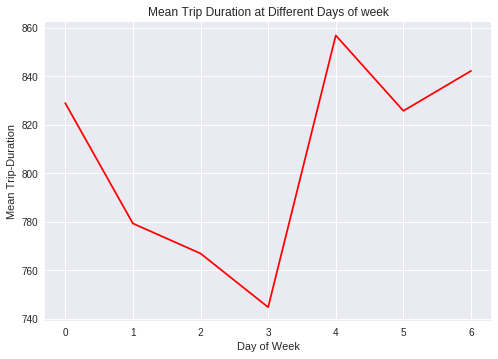

In [0]:
day_week=train_df.groupby(by='day_of_week',as_index=False)['trip_duration'].mean()

plt.plot(day_week['day_of_week'],day_week['trip_duration'],c='r')
plt.title("Mean Trip Duration at Different Days of week")
plt.xlabel("Day of Week")
plt.ylabel("Mean Trip-Duration")
plt.show()

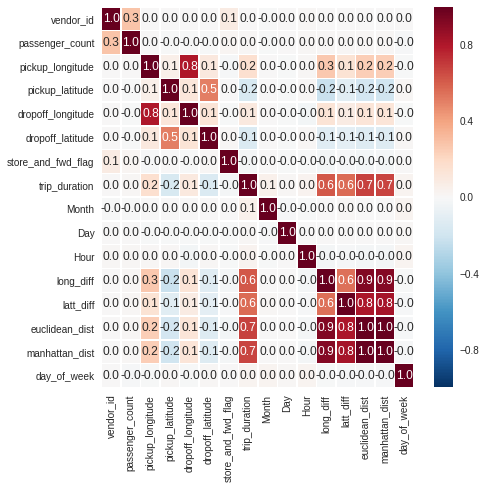

In [0]:
import seaborn as sns

f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

In [0]:
train_df.columns.to_series().groupby(train_df.dtypes).groups

{dtype('int64'): Index(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'trip_duration',
        'Month', 'Day', 'Hour', 'day_of_week'],
       dtype='object'),
 dtype('float64'): Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'long_diff', 'latt_diff', 'euclidean_dist',
        'manhattan_dist'],
       dtype='object')}

In [16]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import preprocessing

print(train_df.shape)
print(test_df.shape)

col_to_category=["vendor_id","passenger_count","store_and_fwd_flag","Month","Day","Hour","day_of_week"]
label_encoder = preprocessing.LabelEncoder()

for col in col_to_category:
    train_df[col] = label_encoder.fit_transform(train_df[col].astype(str))


display(train_df.dtypes)  
  
ftr_col=[col for col in test_df.columns]
train_ftr=train_df[ftr_col]
train_lbl=train_df['trip_duration']

X_train, X_val, y_train, y_val = train_test_split(train_ftr, train_lbl, test_size=0.4, random_state=42)

(1444065, 16)
(625134, 15)


vendor_id               int64
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag      int64
trip_duration           int64
Month                   int64
Day                     int64
Hour                    int64
long_diff             float64
latt_diff             float64
euclidean_dist        float64
manhattan_dist        float64
day_of_week             int64
dtype: object

In [0]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y_test, predictions):
  
  loss=  np.sqrt(mean_squared_log_error( np.abs(y_test), np.abs(predictions) ))
  return 'rmsle',loss,False
  

In [17]:
import lightgbm 
from sklearn.metrics import mean_squared_log_error




params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1,
    'num_iterations' : 20000
}

gbm = lightgbm.LGBMRegressor() 
gbm.set_params(**params)

gbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=rmsle,
    early_stopping_rounds=50,
    verbose=100,
    categorical_feature=col_to_category
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1190: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Day', 'Hour', 'Month', 'day_of_week', 'passenger_count', 'store_and_fwd_flag', 'vendor_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 350.872	valid_0's rmsle: 0.556006
[200]	valid_0's rmse: 293.718	valid_0's rmsle: 0.466532
[300]	valid_0's rmse: 276.291	valid_0's rmsle: 0.430393
[400]	valid_0's rmse: 268.119	valid_0's rmsle: 0.414096
[500]	valid_0's rmse: 262.715	valid_0's rmsle: 0.404631
[600]	valid_0's rmse: 259.052	valid_0's rmsle: 0.398713
[700]	valid_0's rmse: 255.935	valid_0's rmsle: 0.394124
[800]	valid_0's rmse: 253.702	valid_0's rmsle: 0.39106
[900]	valid_0's rmse: 251.872	valid_0's rmsle: 0.388605
[1000]	valid_0's rmse: 250.301	valid_0's rmsle: 0.38674
[1100]	valid_0's rmse: 249.085	valid_0's rmsle: 0.385212
[1200]	valid_0's rmse: 248.09	valid_0's rmsle: 0.383815
[1300]	valid_0's rmse: 247.364	valid_0's rmsle: 0.382745
[1400]	valid_0's rmse: 246.876	valid_0's rmsle: 0.38207
[1500]	valid_0's rmse: 246.301	valid_0's rmsle: 0.381277
[1600]	valid_0's rmse: 245.701	valid_0's rmsle: 0.380431
[1700]	valid_0's rmse: 245.338	valid_0'

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.6, importance_type='split', learning_rate=0.01,
       max_depth=15, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_iterations=20000, num_leaves=200,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [0]:
y1_lgb = gbm.predict(X_val)
y1_lgb=np.array(y1_lgb).reshape(len(y1_lgb),1)
y1_lgb=pd.DataFrame(y1_lgb,columns=['Pred_LGB'])
y1_lgb.to_csv('LGB.csv',index=False)

In [0]:
ytest_lgb = gbm.predict(test_df)
ytest_lgb=np.array(ytest_lgb).reshape(len(ytest_lgb),1)
ytest_lgb=pd.DataFrame(ytest_lgb,columns=['Pred_LGB'])
ytest_lgb.to_csv('LGB_test.csv',index=False)

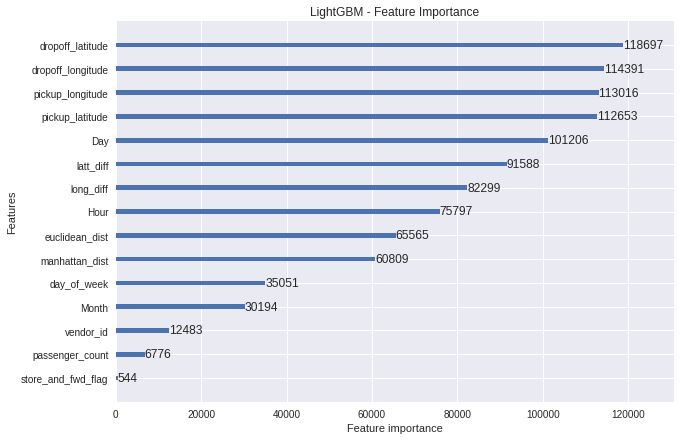

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 7))
lightgbm.plot_importance(gbm, max_num_features=30, ax=ax)
plt.title("LightGBM - Feature Importance");

In [0]:
!pip install shap

    100% |████████████████████████████████| 225kB 8.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/3a/5d/18/1f604dd6b90e4e9059263f4c589d57934c0efbf6c726b75898
Successfully built shap


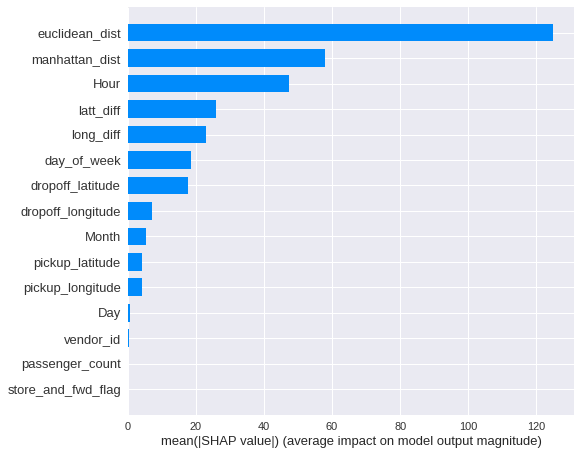

In [0]:

import shap
shap.initjs()

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type='bar')

In [0]:
from sklearn.metrics import mean_squared_log_error
def rmsle(preds, d_train):
  labels = d_train.get_label()
  loss=  np.sqrt(mean_squared_log_error( np.abs(preds), np.abs(labels) ))
  return 'rmsle',loss

In [23]:
import xgboost as xgb



parameters = {'nthread':4, #when use hyperthread, xgboost may become slower
              'objective':'reg:linear',
              'learning_rate': 0.05, #so called `eta` value
              'max_depth': 6,
              'min_child_weight': 4,
              'silent': 1,
              'subsample': 0.7,
              'colsample_bytree': 0.7,
              'n_estimators': 500,
              }
d_train=xgb.DMatrix(X_train.values, label=y_train.values)
d_val=xgb.DMatrix(X_val.values, label=y_val.values)
watchlist = [(d_val, 'val'), (d_train, 'train')]

model=xgb.train(parameters,d_train,num_boost_round=1000,evals=watchlist, feval=rmsle, early_stopping_rounds=20, verbose_eval=10)

[0]	val-rmse:946.6	train-rmse:947.809	val-rmsle:2.88825	train-rmsle:2.88804
Multiple eval metrics have been passed: 'train-rmsle' will be used for early stopping.

Will train until train-rmsle hasn't improved in 20 rounds.
[10]	val-rmse:625.054	train-rmse:625.854	val-rmsle:0.858773	train-rmsle:0.858443
[20]	val-rmse:451.688	train-rmse:452.236	val-rmsle:0.543924	train-rmsle:0.543369
[30]	val-rmse:365.533	train-rmse:365.881	val-rmsle:0.457904	train-rmsle:0.45715
[40]	val-rmse:326.375	train-rmse:326.539	val-rmsle:0.436344	train-rmsle:0.435448
[50]	val-rmse:308.698	train-rmse:308.719	val-rmsle:0.433471	train-rmsle:0.432434
[60]	val-rmse:299.084	train-rmse:299.002	val-rmsle:0.431622	train-rmsle:0.430503
[70]	val-rmse:293.856	train-rmse:293.669	val-rmsle:0.430826	train-rmsle:0.42961
[80]	val-rmse:289.978	train-rmse:289.644	val-rmsle:0.42907	train-rmsle:0.427755
[90]	val-rmse:286.878	train-rmse:286.464	val-rmsle:0.426066	train-rmsle:0.42463
[100]	val-rmse:284.378	train-rmse:283.865	val-rmsle:

In [24]:
d_val = xgb.DMatrix(X_val.values)
y1_xgb = model.predict(d_val, ntree_limit=model.best_ntree_limit)
print(y1_xgb.shape)
y1_xgb=np.array(y1_xgb).reshape(len(y1_xgb),1)
y1_xgb=pd.DataFrame(y1_xgb,columns=['Pred_XGB'])
y1_xgb.to_csv('XGB.csv',index=False)

(577626,)


In [25]:
d_test = xgb.DMatrix(test_df.values)
ytest_xgb = model.predict(d_test, ntree_limit=model.best_ntree_limit)
print(ytest_xgb.shape)
ytest_xgb=np.array(ytest_xgb).reshape(len(ytest_xgb),1)
ytest_xgb=pd.DataFrame(ytest_xgb,columns=['Pred_XGB'])
ytest_xgb.to_csv('XGB_test.csv',index=False)

(625134,)


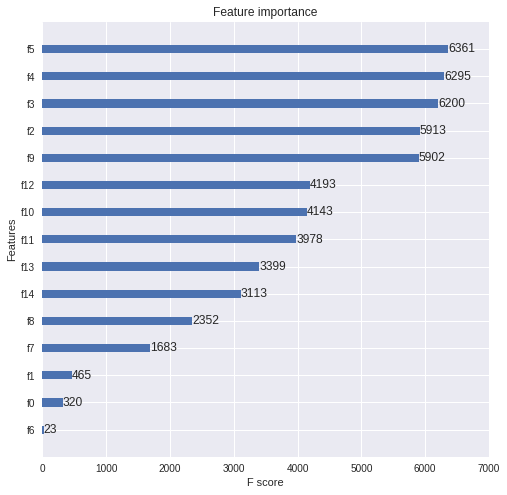

In [35]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))
xgb.plot_importance(model, max_num_features=50, height=0.3, ax=ax)
plt.show()

In [20]:
!pip install catboost

    100% |████████████████████████████████| 55.5MB 881kB/s 


In [0]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y_test, predictions):
  
  loss=  np.sqrt(mean_squared_log_error( np.abs(y_test), np.abs(predictions) ))
  return 'rmsle',loss,False

In [0]:
cat_idx=[]

for idx,col in enumerate(test_df.columns):
  if col in col_to_category:
    cat_idx.append(idx)
  

In [27]:
from catboost import CatBoostRegressor

model =  CatBoostRegressor(iterations=1000,
                             learning_rate=0.05,
                             depth=16,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             early_stopping_rounds=10,
                             use_best_model=True,
                             verbose=5)
model.fit(X_train, y_train,
                 eval_set=(X_val, y_val),
                 cat_features=cat_idx,
                 use_best_model=True)

0:	learn: 948.5481270	test: 947.4078277	best: 947.4078277 (0)	total: 7.94s	remaining: 2h 12m 13s
5:	learn: 764.0347507	test: 763.3099534	best: 763.3099534 (5)	total: 45.4s	remaining: 2h 5m 29s
10:	learn: 626.6219571	test: 626.1302562	best: 626.1302562 (10)	total: 1m 13s	remaining: 1h 50m 51s
15:	learn: 527.0850857	test: 526.7568591	best: 526.7568591 (15)	total: 1m 39s	remaining: 1h 41m 37s
20:	learn: 452.5798330	test: 452.3589120	best: 452.3589120 (20)	total: 2m 15s	remaining: 1h 45m 21s
25:	learn: 399.7369355	test: 399.6070840	best: 399.6070840 (25)	total: 2m 52s	remaining: 1h 47m 58s
30:	learn: 362.7048437	test: 362.6772267	best: 362.6772267 (30)	total: 3m 30s	remaining: 1h 49m 51s
35:	learn: 336.1249961	test: 336.0538991	best: 336.0538991 (35)	total: 4m 7s	remaining: 1h 50m 34s
40:	learn: 318.0074318	test: 317.9547397	best: 317.9547397 (40)	total: 4m 45s	remaining: 1h 51m 12s
45:	learn: 305.3954532	test: 305.4577054	best: 305.4577054 (45)	total: 5m 23s	remaining: 1h 51m 46s
50:	lear

In [0]:
y1_cat = model.predict(X_val)
y1_cat=np.array(y1_cat).reshape(len(y1_cat),1)
y1_cat=pd.DataFrame(y1_cat,columns=['Pred_CAT'])
y1_cat.to_csv('CAT.csv',index=False)

In [0]:
ytest_cat = model.predict(test_df)
ytest_cat=np.array(ytest_cat).reshape(len(ytest_cat),1)
ytest_cat=pd.DataFrame(ytest_cat,columns=['Pred_CAT'])
ytest_cat.to_csv('CAT_test.csv',index=False)

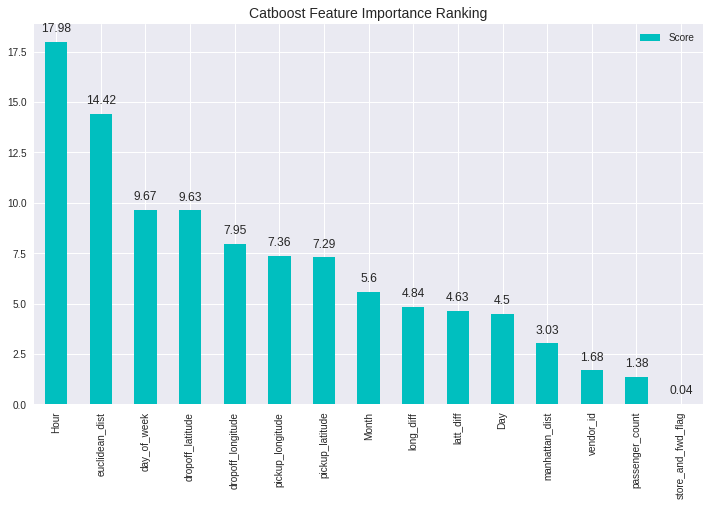

In [33]:
import matplotlib.pyplot as plt

feature_score = pd.DataFrame(list(zip(X_train.dtypes.index, model.get_feature_importance())),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [39]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=7, criterion='mse' ,n_estimators=200, verbose=5)
regr.fit(X_train.values, y_train.values)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 200


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.5s remaining:    0.0s


building tree 2 of 200


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


building tree 3 of 200


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.5s remaining:    0.0s


building tree 4 of 200


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.1s remaining:    0.0s


building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed: 15.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=None, verbose=5, warm_start=False)

In [40]:
y1_rf = regr.predict(X_val)
y1_rf = np.array(y1_rf).reshape(len(y1_rf),1)
y1_rf = pd.DataFrame(y1_rf,columns=['Pred_RF'])
y1_rf.to_csv('RF.csv',index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    7.3s finished


In [41]:
ytest_rf = regr.predict(test_df)
ytest_rf=np.array(ytest_rf).reshape(len(ytest_rf),1)
ytest_rf=pd.DataFrame(ytest_rf,columns=['Pred_RF'])
ytest_rf.to_csv('RF_test.csv',index=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    6.4s finished


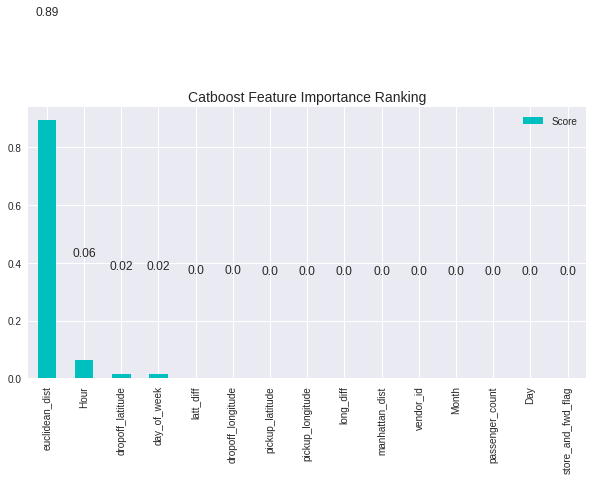

In [44]:
regr.feature_importances_

feature_score = pd.DataFrame(list(zip(X_train.dtypes.index,regr.feature_importances_)),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

plt.rcParams["figure.figsize"] = (10,5)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [49]:
stage2_train_len=int(0.9*X_val.shape[0])
X_train2=X_val.iloc[:stage2_train_len, :]
X_val2=X_val.iloc[stage2_train_len: ,:]
y_train2=y_val.iloc[:stage2_train_len]
y_val2=y_val.iloc[stage2_train_len: ]
print(X_train2.shape," ",y_train2.shape)
print(X_val2.shape," ",y_val2.shape)

(519863, 15)   (519863,)
(57763, 15)   (57763,)


In [0]:
import pandas as pd

def buildEnsamble(file1,file2,file3,file4):
  lgb=pd.read_csv(file1)
  xgb=pd.read_csv(file2)
  cat=pd.read_csv(file3)
  rf=pd.read_csv(file4)
  
  ens=pd.DataFrame()
  ens["Pred_LGB"]=lgb["Pred_LGB"]
  ens["Pred_XGB"]=xgb["Pred_XGB"]
  ens["Pred_CAT"]=cat["Pred_CAT"]
  ens["Pred_RF"]=rf["Pred_RF"]
  
  return ens

In [51]:
ens=buildEnsamble("LGB.csv","XGB.csv","CAT.csv","RF.csv")
print(ens.shape)
print(ens.head())

(577626, 4)
      Pred_LGB    Pred_XGB     Pred_CAT      Pred_RF
0   427.603493   471.59906   377.271167   382.824518
1  1076.947644   995.47320  1135.294406  1095.113575
2  1623.796616  1624.27040  1675.247316  1579.544309
3  1045.365371   960.45930  1162.447922   910.877094
4   557.762247   535.59960   550.702969   535.048991


In [52]:
ens_train=ens.iloc[:stage2_train_len, :]
ens_val=ens.iloc[stage2_train_len: ,:]

print(ens_train.shape)
print(ens_val.shape)

(519863, 4)
(57763, 4)


In [54]:
import lightgbm 
from sklearn.metrics import mean_squared_log_error


params = {
    'objective' : 'regression',
    'metric' : 'rmse',
    'num_leaves' : 200,
    'max_depth': 15,
    'learning_rate' : 0.01,
    'feature_fraction' : 0.6,
    'verbosity' : -1,
    'num_iterations' : 10000
}

gbm = lightgbm.LGBMRegressor() 
gbm.set_params(**params)

gbm.fit(
    ens_train,
    y_train2,
    eval_set=[(ens_train,y_train2),(ens_val, y_val2)],
    eval_metric=rmsle,
    early_stopping_rounds=10,
    verbose=100,
    
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:116: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 10 rounds.
[100]	training's rmse: 303.996	training's rmsle: 0.509753	valid_1's rmse: 302.944	valid_1's rmsle: 0.506978
[200]	training's rmse: 244.784	training's rmsle: 0.407828	valid_1's rmse: 245.137	valid_1's rmsle: 0.406612
[300]	training's rmse: 235.263	training's rmsle: 0.376038	valid_1's rmse: 236.3	valid_1's rmsle: 0.375691
[400]	training's rmse: 233.659	training's rmsle: 0.366154	valid_1's rmse: 235.118	valid_1's rmsle: 0.366403
Early stopping, best iteration is:
[486]	training's rmse: 233.247	training's rmsle: 0.362987	valid_1's rmse: 234.988	valid_1's rmsle: 0.36359


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.6, importance_type='split', learning_rate=0.01,
       max_depth=15, metric='rmse', min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_iterations=10000, num_leaves=200,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [55]:
ens_test=buildEnsamble("LGB_test.csv","XGB_test.csv","CAT_test.csv","RF_test.csv")
print(ens_test.shape)

(625134, 4)


In [56]:
pred = gbm.predict(ens_test)
pred = np.array(pred).reshape(len(pred),1)
print(pred.shape)

sub=pd.read_csv("test.csv",usecols=['id'])
sub['trip_duration']=pred
sub.to_csv('final_prediction.csv',index=False)

(625134, 1)


In [58]:
!pip install shap

    100% |████████████████████████████████| 225kB 7.3MB/s 
  Stored in directory: /root/.cache/pip/wheels/3a/5d/18/1f604dd6b90e4e9059263f4c589d57934c0efbf6c726b75898
Successfully built shap


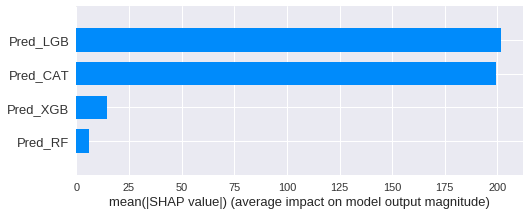

In [59]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(ens_val)
shap.summary_plot(shap_values, ens_val, plot_type='bar')

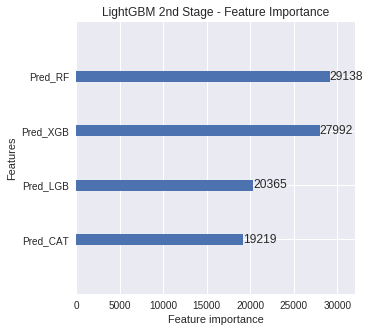

In [61]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
lightgbm.plot_importance(gbm, max_num_features=4, ax=ax)
plt.title("LightGBM 2nd Stage - Feature Importance");

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


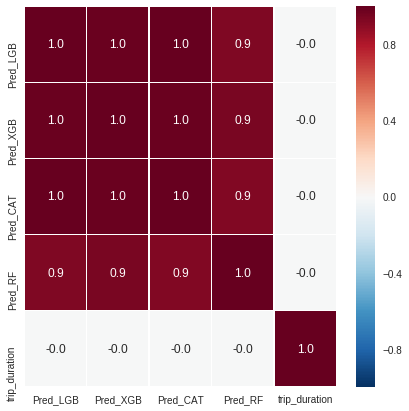

In [65]:
df_corr=ens_train
df_corr["trip_duration"]=y_train2

import seaborn as sns

f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(df_corr.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()